**Libraries**

In [2]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cmasher as cmr
from tqdm import tqdm

**Boundry Conditions**

In [64]:
DOMAIN_SIZE = 1.0
N_POINTS = 41
N_TIME_STEPS = 100
TIME_STEP_LENGTH = 0.1

KINEMATIC_VISCOSITY = 0.001

MAX_ITER_CG = None

**Force Function**

In [54]:
def forcing_function(time, point):
    time_decay = np.maximum(
        2.0 - 0.5 * time,
        0.0,
    )

    forced_value = (
        time_decay
        *
        np.where(
            (
                (point[0] > 0.4)
                &
                (point[0] < 0.6)
                &
                (point[1] > 0.1)
                &
                (point[1] < 0.3)
            ),
            np.array([0.0, 1.0]),
            np.array([0.0, 0.0]),
        )
    )

    return forced_value

**Simulation Function**

/tmp/ipykernel_20177/20096280.py:125: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contour.collections:
/tmp/ipykernel_20177/20096280.py:135: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return contour.collections + [quiv]


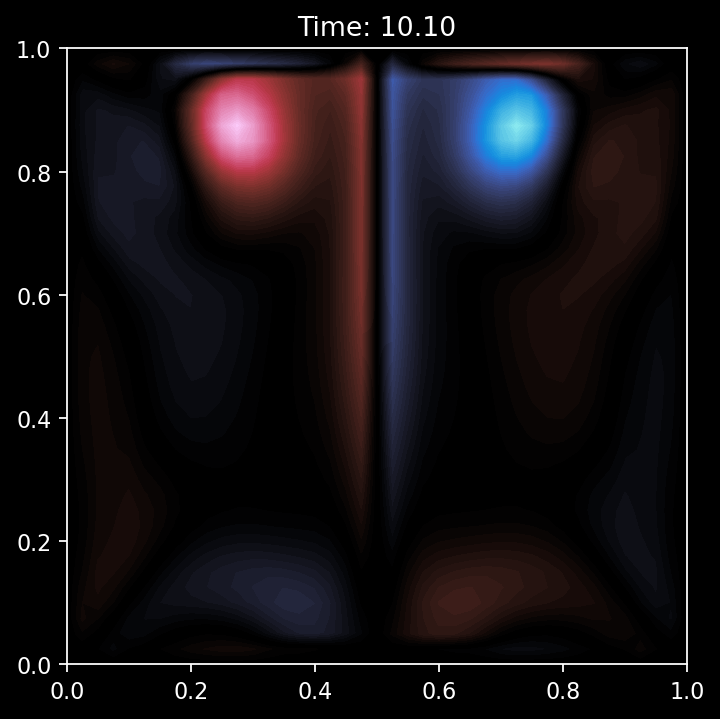

In [56]:
def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    scalar_shape = (N_POINTS, N_POINTS)
    scalar_dof = N_POINTS**2
    vector_shape = (N_POINTS, N_POINTS, 2)
    vector_dof = N_POINTS**2 * 2

    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    X, Y = np.meshgrid(x, y, indexing="ij")

    coordinates = np.concatenate(
        (
            X[..., np.newaxis],
            Y[..., np.newaxis],
        ),
        axis=-1,
    )

    forcing_function_vectorized = np.vectorize(
        pyfunc=forcing_function,
        signature="(),(d)->(d)",
    )

    def partial_derivative_x(field):
        diff = np.zeros_like(field)
        diff[1:-1, 1:-1] = (
            (field[2:  , 1:-1] - field[0:-2, 1:-1]) / (2 * element_length)
        )
        return diff

    def partial_derivative_y(field):
        diff = np.zeros_like(field)
        diff[1:-1, 1:-1] = (
            (field[1:-1, 2:  ] - field[1:-1, 0:-2]) / (2 * element_length)
        )
        return diff

    def laplace(field):
        diff = np.zeros_like(field)
        diff[1:-1, 1:-1] = (
            (field[0:-2, 1:-1] + field[1:-1, 0:-2] - 4 * field[1:-1, 1:-1] + field[2:  , 1:-1] + field[1:-1, 2:  ]) / (element_length**2)
        )
        return diff

    def divergence(vector_field):
        return partial_derivative_x(vector_field[..., 0]) + partial_derivative_y(vector_field[..., 1])

    def gradient(field):
        return np.stack((partial_derivative_x(field), partial_derivative_y(field)), axis=-1)

    def curl_2d(vector_field):
        return partial_derivative_x(vector_field[..., 1]) - partial_derivative_y(vector_field[..., 0])

    def advect(field, vector_field):
        backtraced_positions = np.clip(
            coordinates - TIME_STEP_LENGTH * vector_field,
            0.0,
            DOMAIN_SIZE,
        )
        advected_field = interpolate.interpn(
            points=(x, y),
            values=field,
            xi=backtraced_positions,
            bounds_error=False,
            fill_value=None,
        )
        return advected_field

    def diffusion_operator(vector_field_flattened):
        vector_field = vector_field_flattened.reshape(vector_shape)
        diffusion_applied = vector_field - KINEMATIC_VISCOSITY * TIME_STEP_LENGTH * laplace(vector_field)
        return diffusion_applied.flatten()

    def poisson_operator(field_flattened):
        field = field_flattened.reshape(scalar_shape)
        poisson_applied = laplace(field)
        return poisson_applied.flatten()

    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(5, 5), dpi=160)

    velocities_prev = np.zeros(vector_shape)
    time_current = 0.0

    curl = curl_2d(velocities_prev)
    contour = ax.contourf(X, Y, curl, cmap=cmr.redshift, levels=100)
    magnitude = np.sqrt(velocities_prev[..., 0]**2 + velocities_prev[..., 1]**2)
    quiv = ax.quiver(X, Y, velocities_prev[..., 0], velocities_prev[..., 1], magnitude, cmap="hsv")
    ax.set_title(f"Time: {time_current:.2f}")

    def update(frame):
        nonlocal velocities_prev, time_current, contour, quiv
        time_current += TIME_STEP_LENGTH

        forces = forcing_function_vectorized(time_current, coordinates)

        velocities_forces_applied = velocities_prev + TIME_STEP_LENGTH * forces

        velocities_advected = advect(velocities_forces_applied, velocities_forces_applied)

        velocities_diffused = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(vector_dof, vector_dof),
                matvec=diffusion_operator,
            ),
            b=velocities_advected.flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(vector_shape)

        pressure = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(scalar_dof, scalar_dof),
                matvec=poisson_operator,
            ),
            b=divergence(velocities_diffused).flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(scalar_shape)

        velocities_projected = velocities_diffused - gradient(pressure)

        velocities_prev = velocities_projected

        for c in contour.collections:
            c.remove()
        curl = curl_2d(velocities_projected)
        contour = ax.contourf(X, Y, curl, cmap=cmr.redshift, levels=100)

        magnitude = np.sqrt(velocities_projected[..., 0]**2 + velocities_projected[..., 1]**2)
        quiv.set_UVC(velocities_projected[..., 0], velocities_projected[..., 1], magnitude)

        ax.set_title(f"Time: {time_current:.2f}")

        return contour.collections + [quiv]

    ani = animation.FuncAnimation(
        fig, update, frames=N_TIME_STEPS, blit=False, interval=1000
    )

    ani.save('mu = .gif', writer='imagemagick', fps=20)

if __name__ == "__main__":
    main()